In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cartpole


In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.integrator import DelIntegrator
from varitop.problem import VaritopProblem
from varitop.misc import euler_quadrature

import casadi as cs
import numpy as np

Matplotlib created a temporary cache directory at /tmp/matplotlib-ofcos037 because the default path (/home/mambauser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
steps = 200
t0 = 0
tf = 1
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q_0 = np.array([0, 0, 0, -1])
q_f = np.array([0, 0, 0, 1])

In [4]:
nodes = 200
problem = VaritopProblem()
problem.set_nodes(nodes)
problem.set_quadrature(euler_quadrature)

In [5]:
qs = problem.create_state("q", 4)
vs = problem.create_velocity("v", 4)
us = problem.create_control("u", 1)

In [6]:
q, v, u = qs[0], vs[0], us[0]
q, v, u

(SX([q_0, q_200, q_400, q_600]), SX([v_0, v_200, v_400, v_600]), SX(u_0))

In [7]:
kinetic_energy = cs.Function("kinetic", [q, v], [0.5 * v.T @ v])
potential_energy = cs.Function("potential", [q, v], [9.81 * (q[3])])
total_energy = cs.Function(
    "total", [q, v], [kinetic_energy(q, v) + potential_energy(q, v)]
)
lagrangian = cs.Function("L", [q, v], [kinetic_energy(q, v) - potential_energy(q, v)])
momentum = cs.Function("momentum", [q, v], [cs.jacobian(kinetic_energy(q, v), v)])

In [8]:
phi0 = cs.Function("phi0", [q], [q[1]])
phi1 = cs.Function("phi1", [q], [(q[2] - q[0]) ** 2 + (q[3] - q[1]) ** 2 - 1])

In [9]:
problem.add_constraints("=", [phi0, phi1])

In [10]:
lagrangian

Function(L:(i0[4],i1[4])->(o0) SXFunction)

In [11]:
problem.set_continuous_lagrangian(lagrangian)

In [12]:
cdel_res = problem.get_composite_del_residual(dt=10)
cdel_res

Function(composition:(q[200x4],u[200],lambda[198x2])->(residual[1x1188]) SXFunction)

In [13]:
q_guess = np.full((nodes, 4), q_0)  # q0 for all nodes
q_guess = np.reshape(q_guess, (-1, 1))
u_guess = np.full((nodes, 1), 100)
u_guess = np.reshape(u_guess, (-1, 1))
lambda_guess = np.zeros(((nodes - 2) * 2, 1))

In [14]:
q_sol = cs.SX.sym("q_sol", (nodes, 4))
u_sol = cs.SX.sym("u_sol", (nodes, 1))
lambdas = cs.SX.sym("lambdas", (nodes - 2, 2))
qst = q_sol.T.reshape((-1, 1))
ust = u_sol.T.reshape((-1, 1))
lst = lambdas.T.reshape((-1, 1))
var = cs.vcat([qst, u_sol, lst])

nlp = {
    "x": var,
    "f": u_sol.T @ u_sol,
    "g": cs.hcat(
        [
            cdel_res(q_sol, u_sol, lambdas),
            (q_sol[0, :].T - q_0).T,
            (q_sol[-1, 3].T - q_f[3]).T,
            (q_sol[-2, :].T - q_sol[-1, :].T).T,
        ]
    ),
}
solver = cs.nlpsol("solver", "ipopt", nlp)
res = solver(x0=[*q_guess, *u_guess, *lambda_guess], lbg=0, ubg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5350
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2176

Total number of variables............................:     1396
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1197
Total number of inequality c

In [15]:
qs_opt = np.array(res["x"][: nodes * 4]).reshape((nodes, 4))

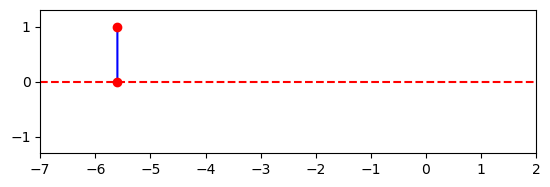

In [19]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()

# Set the x and y limits of the plot
ax.set_xlim(-7, 2)
ax.set_ylim(-1.3, 1.3)
ax.set_aspect("equal")

# Create a line object for the line between the points
(line,) = ax.plot([], [], "b-")

# Create a scatter plot for the points
(points,) = ax.plot([], [], "ro")

# Create a horizontal line at qs_opt[1]
horizontal_line = ax.axhline(y=qs_opt[1, 1], color="r", linestyle="--")


# Animation update function
def update(frame):
    # Update the line and points data
    current = qs_opt[frame]
    line.set_data(current[[0, 2]], current[[1, 3]])
    points.set_data(current[[0, 2]], current[[1, 3]])
    # ax.set_xlim(-8, current[0] + 1.3)
    return line, points


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_opt), interval=60, blit=True)

# Show the plot
animation.save("test.gif", writer="pillow")